# MSDS 460 Final Project

How can we build a fully interconnected network of protected bike lanes in Chicago? How can we do that for as little money as possible?

The goal is to have these lanes separated by a half a mile, each lane is continuous in its entirety, and lanes will cover the entirety of Chicago. In calculating the cost function, we will use existing lanes as much as possible since they are (effectively) free since they already exist

Fortunately Chicago is divided into a very easy to navigate grid. The city has arterial roads every half mile. These are not likely to be the best roads to use for the bike network in many places, but they would be a good basis creating boundaries on possible bike routes.

To that end, I will solve a separate problem for each continuous bike lane, and create a cost function that penalizes any street that is more than an eighth of a mile from its associated arterial. This allows for flexibility in situations where no possible route exists within an eighth of a mile.

A second cost function will be to minimize the construction costs. Existing protected bike lanes or paths will have no cost, buffered bike lanes will add a slight cost, non-buffered bike lanes add more cost, and streets without any lane whatsoever will add the most.

Finally, each path will have a constraint matrix that ensures connectivity along the length of the path.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ipympl

# map stuff
import geopandas as gpd # to handle all of the geometric/geographic data.
from shapely.geometry import Polygon, Point, LineString # for easily creating masks
from shapely.ops import split # for splitting the boundaries etc as needed
import fiona # for kml
# tell fiona to allow geopandas to read a .kml file
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

# time -- for timestamping stuff if we're running something long
import time


# # start with using PuLP
# # Combining all of the potential routes
# from pulp import LpProblem, LpMinimize

# using lpsolve so that we can just use matrices. I find that easier
import lpsolve55
import lp_maker

#### Support functions
A notification function that will text me. This way I can work on other things while longer pieces of code run

In [2]:
import smtplib
import ssl
from os import getenv

# To send a text when you've finished everything
class doneText():
    def __init__(self):
        self.notif_email = getenv('notif_email') # source for this email
        self.notif_pass = getenv('notif_pass')   # pass for the source email
        self.notif_target = getenv('notif_target') # target email [phone_num]@[mmsgateway]

    def send(self, message):
        ssl_context = ssl.create_default_context()
        with smtplib.SMTP_SSL('smtp.gmail.com', 465, context=ssl_context) as server:
            server.login(self.notif_email, self.notif_pass)
            result = server.sendmail(self.notif_email, self.notif_target, f"Subject:\n{message}")

            print(f"Text send result: {result}")
            server.quit()


dntxt = doneText() # initialize an instance

### Importing existing geographic data
To determine where the bike lanes should go, I need to know where all of the streets in Chicago are, where the current bike lanes and trails are, and where the edges of the city are

I'm getting the locations of the streets, the locations of the bike paths and protected bike lanes, city borders etc from the <a href=https://data.cityofchicago.org>Chicago Open Data Portal </a>

I wasn't able to find the Lakefront Trail (the jewel of the city) on the Open Data portal, so I grabbed it from the parks department website

In [3]:
# file paths
routes_fpath = ".\\BikeRoutes.zip" # 'bike routes' in chicago
boundaries_fpath = ".\\Boundaries-City.zip" # Chicago geographic border
fpdcc_fpath = ".\\FPDCCTrail.zip" # Off street paths in the forest preserves
lft_fpath = ".\\LakefrontTrailMap.kml" # LFT -- will need to be joined
street_fpath = ".\\center_line.zip" # centers of all streets in the city limits

# load them in to geoPandas dataframes
routes_df = gpd.read_file(routes_fpath) # bike lanes, 'bike routes' (streets with arrows) in Chicago
boundaries_df = gpd.read_file(boundaries_fpath) # boundaries of Chicago
fpdcc_df = gpd.read_file(fpdcc_fpath) # off-street paths in the forest preserves
lft_df = gpd.read_file(lft_fpath)
street_df = gpd.read_file(street_fpath)

# the forest service data is using a different crs from everyone else
# To get info about the different CRS types, refer to the ESRI website
# esri.io/?=
fpdcc_df.to_crs(crs=routes_df.crs, inplace=True)


# Apparently so are the streets, even though that's provided by City of Chicago
street_df.to_crs(crs=routes_df.crs, inplace=True)

Like many cities, Chicago has a bit of a weird border. One of its bizarre portions is the segment in the northwest that encloses O'Hare airport.

While I do think that we should be able to get to the airport by bikes, we'll drop that area for now to make this all a bit easier

Text(0.5, 1.0, 'Chicago without Ohare')

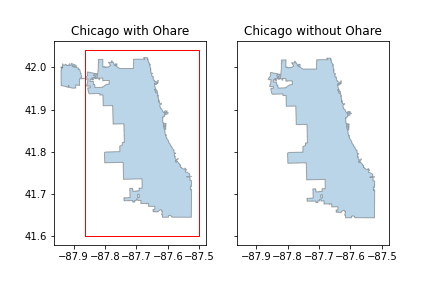

In [4]:
# an initial look at the boundaries
fig_0, ax_0 = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

boundaries_df.plot(ax=ax_0[0], edgecolor='k', alpha=.3)
ax_0[0].set_title('Chicago with Ohare')

# create a dataframe to mask out ohare.
lat_point_list = [41.6, 41.6, 42.04, 42.04]
long_point_list = [-87.864, -87.5, -87.5, -87.864]
poly_geom = Polygon(zip(long_point_list, lat_point_list))
mask = gpd.GeoDataFrame(index=[0], crs=boundaries_df.crs, geometry=[poly_geom])
mask.plot(ax=ax_0[0], edgecolor='r', color=[0, 0, 0, 0])

# mask it
boundaries_nohare_df = gpd.clip(boundaries_df, mask, keep_geom_type=True)
boundaries_nohare_df.plot(ax = ax_0[1], edgecolor='k', alpha=.3)
ax_0[1].set_title('Chicago without Ohare')

In [5]:
# Run a unary union over the boundaries dataset, just so it's a single combined unit
boundaries_nohare_df.loc[:,'geometry'] = gpd.GeoSeries(boundaries_nohare_df['geometry'].unary_union)
boundaries_nohare_df = boundaries_nohare_df.set_crs(boundaries_df.crs)


Now for the existing bike lanes

In [6]:
# Let's take a look at what we're currently dealing with. 
# How many protected bike lanes do we have?
routes_df['displayrou'].value_counts(dropna=False)


BIKE LANE                321
BUFFERED BIKE LANE       249
SHARED-LANE              135
PROTECTED BIKE LANE      101
NEIGHBORHOOD GREENWAY     77
Name: displayrou, dtype: int64

Each of these categories has a specific definition. 

- <b>Protected Bike Lanes</b> are separated from traffic using physical barriers. The ideal is concrete bollards or similar, since the flexible plastic posts frequently get destroyed by drivers. For our purposes these will have an installation cost of 0, since they already exist
- <b>Buffered Bike Lanes</b> are separated by a painted buffer space. While the paint will do little to stop a car, the extra space adds a little more breathing room, and the buffer space can be used to install physical barriers in the future. These will have a lower installation cost, since the space has already been set aside
- <b>Bike Lane</b> in this context means a painted lane on the ground. These are typically on the right most edge of the street, next to parked cars.
- <b>Shared-Lane</b> is a lane meant to be shared by cars and bikes. These are indicated by painted arrows with a bike symbol, also known as "sharrows". This is considered fairly inadequate by most cyclists
- <b>Neighborhood Greenway</b> is a street with traffic calming measures such as roundabouts, speed bumps, and raised intersections for pedestrians. These can be a good balance to remind drivers that they are driving through a neighborhood, not a highway. So many folks forget when they're behind a windshield!

<br>

For this project we are interested in installing fully protected bike lanes. With that in mind, existing protected bike lanes will add 0 cost to the project, buffered bike lanes will add a small cost, bike lanes will add a slightly higher cost. Shared lanes and Neighborhood greenways will be completely disregarded, since they will need all of the same infrastructure as a protected bike lane added on any other street. 

In [7]:
# drop the shared lanes and greenways
drop_ind = routes_df.loc[routes_df['displayrou'].isin(['SHARED-LANE','NEIGHBORHOOD GREENWAY'])].index
routes_df.drop(index=drop_ind, inplace=True)


# Change column names and drop unneeded columns
drop_cols = ['f_street', 'mi_ctrline', 'objectid', 't_street']
rename_cols = {'displayrou':'type', 'street':'name'}
routes_df.drop(columns=drop_cols, inplace=True, errors='ignore')
routes_df.rename(columns=rename_cols, inplace=True)

The Lakefront Trail route is currently split into different segments, so we will need to combine those

In [8]:
# create a new dataframe for the combined data
lft_comb_df = gpd.GeoDataFrame()
lft_comb_df.loc[0,'name'] = 'Lakefront Trail' # name for the trail
lft_comb_df.loc[0,'type'] = 'Trail' # give it a "displayrou" column
lft_comb_df['geometry'] = gpd.GeoSeries(lft_df.loc[0,'geometry']) # geographic data -- grab it from the first element in the split gpd

# starting with the second element in, combine them
for geo in lft_df.loc[1:,'geometry']:
    lft_comb_df['geometry'] = lft_comb_df.union(geo)

lft_comb_df.loc[:,'cost'] = 0 # cost will be zero
lft_comb_df = lft_comb_df.set_crs(lft_df.crs)

del(lft_df) # just to avoid confusion later on

Cleaning up data from the forest preserves paths. 

Many of them extend outside of the city, so we'll start by clipping them at the borders

In [9]:
# start by dropping the trails that aren't in the city
fpdcc_df['inCity'] = [boundaries_nohare_df.intersects(trail['geometry'])[0] for idx,trail in fpdcc_df.iterrows()]
fpdcc_df.drop(index= fpdcc_df.loc[fpdcc_df['inCity'] == False].index, inplace= True)
fpdcc_df.reset_index(inplace=True, drop=True)
fpdcc_df.loc[:,'type'] = 'Trail' # for combining things later


# then clip the portions to only being in the city
for idx,trail in fpdcc_df.iterrows():
    fpdcc_df.at[idx,'geometry'] = boundaries_nohare_df.intersection(trail['geometry'], align=True)[0]


We only need the name and the geometries for these routes. We'll keep the "type" information for plotting

In [10]:
keep_cols = ['NAME', 'geometry', 'type']
fpdcc_df = fpdcc_df[keep_cols]

fpdcc_df.loc[:,'cost'] = 0 # this is for calculating costs. These already exist
fpdcc_df.rename(columns={'NAME':'name'}, inplace=True)

Now for the street data. 

I am using the <a href=https://data.cityofchicago.org/api/assets/06DEC62C-ACAB-42D3-A540-378F8464F83D?> documentation </a> provided by the data portal to decide what to keep. Several seem to be out of date.

There's a lot of good information here, but we only really need the street name, the street class, the length in feet, and its geometry.

In [11]:
keep_cols = ['STREET_NAM','LENGTH','CLASS','geometry', 'PRE_DIR']

street_df = street_df[keep_cols]
street_df.rename(columns={'STREET_NAM':'name', 'LENGTH':'length', 'PRE_DIR':'pre_dir'}, inplace=True)
street_df.loc[:,'type'] = 'street'


Next, let's drop the highways. There are a few other streets that I don't want to ride (like Western) though I will leave them in the dataset for now.

In [12]:
drop_ind = np.where(street_df['CLASS'].isin(['1','RIV','S','9']))[0]

street_df.drop(index=drop_ind, inplace=True, errors='ignore') # just since we have so many large df
# street_df.set_geometry('geometry')

I'm going to remove ohare from this dataset too.

In [13]:
# I think this will leave us with empty geometries, unfortunately
street_df =  gpd.clip(street_df, boundaries_nohare_df) 

dntxt.send('streets clipping done')


Text send result: {}


### Initial plotting
For a sanity check.

First, let's look at the bike routes

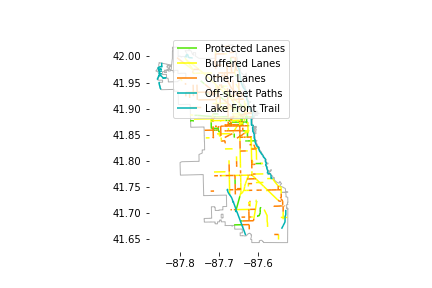

In [14]:
fig,ax = plt.subplots()

boundaries_nohare_df.plot(ax=ax, edgecolor=[0, 0, 0, .3], color=[0, 0, 0, 0])
routes_df.loc[routes_df['type'] == 'PROTECTED BIKE LANE'].plot(ax=ax, color=[.3, .9, 0, 1], label='Protected Lanes')
routes_df.loc[routes_df['type'] == 'BUFFERED BIKE LANE'].plot(ax=ax, color=[1, 1, 0, 1], label='Buffered Lanes')
routes_df.loc[routes_df['type'].isin(['PROTECTED BIKE LANE','BUFFERED BIKE LANE']).eq(0)].plot(ax=ax, color=[1, .5, 0, 1], label='Other Lanes')
fpdcc_df.plot(ax=ax, color=[0, .7, .7, 1], label='Off-street Paths') 
lft_comb_df.plot(ax=ax, color=[0, .7, .7, 1], label='Lake Front Trail')

fig.patch.set_color('white')
ax.spines[:].set_visible(False)
_ = ax.legend()

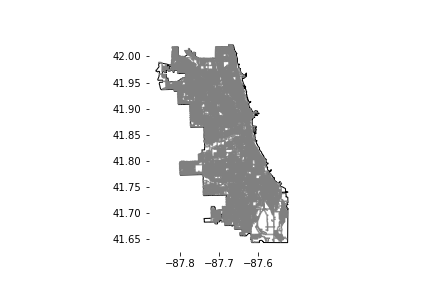

In [15]:
fig,ax = plt.subplots()

street_df.plot(ax=ax, color=[.5, .5, .5, 1])
boundaries_nohare_df.plot(ax=ax, edgecolor = [0, 0, 0, 1], color=[0, 0, 0, 0])

fig.patch.set_color('white')
ax.spines[:].set_visible(False)

#### Project everything into epsg 3857
This CRS is in meters and is better for calculating distances. This is what we will use for the rest of the calculations, and only convert back when we're plotting

In [16]:
# combine all of the possible routes, and project
lft_3857 = lft_comb_df.to_crs(epsg=3857)
fpdcc_3857 = fpdcc_df.to_crs(epsg=3857)
routes_3857 = routes_df.to_crs(epsg=3857)
streets_3857 = street_df.to_crs(epsg=3857)
boundaries_3857 = boundaries_nohare_df.to_crs(epsg=3857)

## "Ideal" bike lanes

I am creating a bike lane for each arterial, so I need to create a set from the arterials in the street dataframe

Many of the arterials have interruptions during their lengths, which would mess up my distance cost function. To account for that, I'm going to create a continuous line that goes from one extreme to the other extreme of the arterial. For example, the furthest East point of an arterial to the furthest West, assuming it's an E/W street.

Additionally, the entire problem for each path will be limited to streets within two miles of the arterial. That makes the constraint matrix a lot smaller.

In [17]:
# group each arterial and geometry based on the street name
arterial_df = streets_3857[streets_3857['CLASS'].eq('2')].dissolve(by='name')

# create a dataframe of these "ideal" bike paths
ideal_list = [[idx,LineString([Point(geom['maxx'],geom['miny']),Point(geom['minx'],geom['maxy'])])]\
               for idx,geom in arterial_df.bounds.iterrows()]
ideal_df = gpd.GeoDataFrame(ideal_list)
ideal_df.rename(columns={0:'Arterial',1:'geometry'}, inplace=True)
ideal_df = ideal_df.set_crs(streets_3857.crs)

# clean it up
# get rid of everything outside of the city
ideal_df = gpd.clip(ideal_df, boundaries_3857)
ideal_df = ideal_df.explode(ignore_index=True) # split multi segments into individual rows
# drop anything less than 3 km
ideal_df.drop(index=ideal_df[ideal_df.length.lt(3000)].index, inplace=True)
ideal_df.reset_index(inplace=True)
ideal_df.drop(columns=['level_0','level_1'], inplace=True)


Clearing up some no longer used variables, since we will be using a fair amount of memory later on. 

This also makes it easier to use the VSCode variable explorer

In [18]:
del(arterial_df, ideal_list, boundaries_df, boundaries_fpath, fpdcc_fpath, lft_fpath, mask, routes_fpath)

## Creating the multi-objective problems

#### Constraints:

To ensure that any block with a bikelane is connected to 1-2 other blocks, we will set the constants for that block to -1, any connected blocks to 1, and any unconnected blocks to 0. We then set the constraint to > 0  

We will also have a row for each end of the arterial, to make sure that the lane spans the length of the arterial. It will consider any road within an 1/8 mile to be "connected".

Everything but the last two rows of the matrix could be the same for every route, but since we have 54000 blocks we will apparently run out of memory on my laptop. 
Instead we will construct a new matrix for each bike path, and limit ourselves to streets within two miles of the arterial. This should work in most situations.

In [19]:
def constraint_constructor(poss_df, ideal_ls):
    n_connects = len(poss_df)
    constraint_LHS = np.zeros([n_connects+2, n_connects])
    constraint_RHS = np.zeros([n_connects+2]) #* -1
    constraint_RHS[-2:] = 1 # since we don't have dec. vars for the boundaries

    cons_idx = 0
    # looking through each block...
    # this should be symmetric, so we'll take advantage of that to make calculations faster
    for idx, row in poss_df.iterrows():
        # typical Right of Way width in Chicago is 66 feet, so anything within 20 meters should be connected
        intersect = poss_df[cons_idx:].buffer(20).intersects(row['geometry'])
        constraint_LHS[cons_idx,cons_idx:] = intersect.astype(int) # all streets that intersect get a 1
        constraint_LHS[cons_idx:-2,cons_idx] = intersect.astype(int) # all streets that intersect get a 1
        constraint_LHS[cons_idx,cons_idx] = -1 # identity gets a -1
        cons_idx += 1 # go to the next row

    # start point 
    # pt_start,pt_end = ideal_ls['geometry'].coords
    pt_start,pt_end = ideal_ls.coords
    constraint_LHS[-2,:] = poss_df.buffer(200).overlaps(Point(pt_start).buffer(200)).astype(int)
    # end point
    constraint_LHS[-1,:] = poss_df.buffer(200).overlaps(Point(pt_end).buffer(200)).astype(int)



    return constraint_LHS, constraint_RHS


#### Objective functions:

The first objective function will be to minimize the distance from the associated arterial. Under 1/8 mile there won't be any penalty, then above that we'll have some multiplier times the distance squared.
This will be a different function for each path, since the arterial will be different

In [20]:
def dist_obj_constructor(arterial_gs, st_df):
    # convert everything into meters
    # arterial = arterial.to_crs(epsg=3857)
    # st_df = st_df.to_crs(epsg=3857)

    # find the distances
    dist = st_df.distance(arterial_gs)

    # Changing the distance into costs
    # We'll use Y = exp((d-200)/50) -- 200 meters approx = 1/8 mile
    # return np.exp((dist-200)/50)
    return np.exp((dist-200)/200)
    

The second objective function is to reduce the cost of construction. Since the cost of installing a Protected Bike Lane on a block will not change, we can just calculate the cost and subindex the blocks of interest for each bike lane.

In [21]:
# highest estimated cost I saw was 500k/mile. 
# That works out to approx $285/meter -- so we'll use that as the cost of "no lane"
# 
# mid range was listed at 100k/mile, or $57/meter. That will be for upgrading plain bike lanes
#
# I found a quote for bollards working out to 600/post. If we install one bollard every
# 5 meters, that works out to $120/meter. That will be added to the costs for "no lane",
# plain bike lanes, and buffered bike lanes
cost_map = {'PROTECTED BIKE LANE':0, 'BUFFERED BIKE LANE':120, 'BIKE LANE':177}

init_ts = time.time()

for idx,route in routes_3857.iterrows():
    block_idx = np.where(streets_3857.intersects(route['geometry']) &\
        streets_3857['pre_dir'].eq(route['pre_dir']))[0]

    block_ind = streets_3857.iloc[block_idx].index

    cost = cost_map[route['type']] 
    streets_3857.loc[block_ind,'cost'] = cost * streets_3857.loc[block_ind,'length']

no_route_idx = streets_3857.isna().index
streets_3857.loc[no_route_idx,'cost'] = 405*streets_3857.loc[no_route_idx,'length']
elapse_ts = time.time() - init_ts

dntxt.send(f"Costs inserted into dataframe.  {int(elapse_ts//60)} minutes, {int(elapse_ts%60)} seconds elapsed")

Text send result: {}


#### Combining all of the potential routes
This will make things easier when we are going through all of our potential routes for a particular lane.



In [22]:
possible_3857 = streets_3857.append([fpdcc_3857, lft_3857], ignore_index=True) # combine them

### Creating and solving the problems for each lane
This will need to be iterated over each lane

In [23]:
actual_paths = dict() # having issues with just inserting into a geopandas dataframe

# for each lane ...
for idx,row in ideal_df.iterrows():
    print(f"Starting Path: {row['Arterial']}")

    # we'll start by looking to see how many blocks we have within 2 km
    subset_df = gpd.GeoDataFrame(possible_3857.loc[(possible_3857.distance(row['geometry']) <= 2000)], crs=possible_3857.crs)
    
    # get the constraints
    print('Constructing Constraints')
    LHS,RHS = constraint_constructor(subset_df, row['geometry']) 
    print('Calculating costs for the objective function')
    cons_costs = np.array(subset_df['cost'])
    dist_costs = dist_obj_constructor(row['geometry'],subset_df)
    
    # add the costs, element-wise
    # costs = dist_costs.add(cons_costs)
    costs = cons_costs

    # everything is going to be gt
    comp = np.ones([RHS.shape[0],])
    comp[-2:] = 0
    comp = comp.tolist()
    vub = np.ones([LHS.shape[1],]).tolist()
    xint = vub

    # since this is technically integer programming, this is going to take a while unfortunately
    lp_handle = lp_maker.lp_maker(costs.tolist(), LHS.tolist(), RHS.tolist(), comp, \
                                vub=vub, xint=xint, setminim=1)
    # lp_handle = lp_maker.lp_maker(costs, LHS, RHS, comp, vub=np.ones(RHS.shape), xint=np.ones(RHS.shape), setminim=1)
    print("Solving the problem")
    lpstat = lpsolve55.lpsolve('solve', lp_handle)
    if lpstat == 1:
        print(f"Unbounded")
    elif lpstat == 2:
        print(f"Infeasible")
    elif lpstat == 0:
        connected = lpsolve55.lpsolve('get_variables', lp_handle)[0]
        if len(connected) > 0:
            actual_paths[idx] = subset_df.iloc[np.where(np.array(connected)>.5)[0]]['geometry'].unary_union
        else:
            print('No streets returned...')

    print(f"Finished path {row['Arterial']}\n--------------------------------\n")
    # _ = input('Press any key to continue')
    try:
        dntxt.send(f"Finished path {row['Arterial']}")
    except:
        pass
    

dntxt.send(f"Bike lanes constructed!")

Starting Path: 103RD
Constructing Constraints
Calculating costs for the objective function
Solving the problem
Finished path 103RD
--------------------------------

Text send result: {}
Starting Path: 111TH
Constructing Constraints
Calculating costs for the objective function
Solving the problem
Finished path 111TH
--------------------------------

Text send result: {}
Starting Path: 119TH
Constructing Constraints
Calculating costs for the objective function
Solving the problem
Finished path 119TH
--------------------------------

Text send result: {}
Starting Path: 31ST
Constructing Constraints
Calculating costs for the objective function
Solving the problem
Finished path 31ST
--------------------------------

Text send result: {}
Starting Path: 47TH
Constructing Constraints
Calculating costs for the objective function
Solving the problem
Finished path 47TH
--------------------------------

Text send result: {}
Starting Path: 55TH
Constructing Constraints
Calculating costs for the obj

MemoryError: 

In [ ]:
print('done')

# Scratch space

This is just for checking through variables, since Jupyter and VSCode don't
play as nicely with gpd as they do with straight pandas /shrug

I am planning to delete this by the time I turn things in, but in case I miss it...

In [ ]:
test_overlap = np.where(street_df.to_crs(epsg=3857).intersects(routes_df.to_crs(epsg=3857).iloc[0]['geometry']) & (street_df['PRE_DIR'].eq(routes_df.iloc[0]['pre_dir'])))[0]


In [ ]:
fig,ax = plt.subplots()

ax.hist(street_df.to_crs(epsg=3857).distance(routes_df.to_crs(epsg=3857).iloc[0]['geometry']), bins=100)

In [ ]:
possible_df

In [ ]:
dd = np.arange(300)

fig,ax = plt.subplots()

ax.plot(dd, np.exp((dd-200)/50))

In [ ]:
ideal_3857 = ideal_df.to_crs(epsg=3857)
streets_3857 = street_df.to_crs(epsg=3857)

for idx,row in ideal_3857.iterrows():
    # temp_gs = gpd.GeoSeries(row['geometry']).set_crs(epsg=3857)
    # print(dist_obj_constructor(temp_gs, streets_3857))
    print(dist_obj_constructor(row['geometry'],streets_3857).min())

In [24]:
actual_gs = gpd.GeoSeries(actual_paths)
actual_df = gpd.GeoDataFrame([ideal_df.iloc[0:19]['Arterial']])
actual_df = actual_df.T

actual_df = actual_df.set_geometry(actual_gs)
actual_df = actual_df.set_crs(ideal_df.crs)

In [114]:
actual_df = actual_df.T
actual_df.index

RangeIndex(start=0, stop=19, step=1)

In [ ]:
for idx,row in ideal_df.iterrows():
    # type(row['geometry'].buffer(1000))
    pt_0,pt_1 = row['geometry'].coords
    
    # split the border through at a line perpendicular to the centroid of the ideal
    if np.abs(pt_1[0] - pt_0[0]) > np.abs(pt_1[1] - pt_0[1]): # it's horizontal
        centroid = (pt_1[0]+pt_0[0])/2
        min_pt = Point(centroid, np.min([pt_0[1], pt_1[1]])-50000) # chicago is less than 50km wide at any point
        max_pt = Point(centroid, np.max([pt_0[1], pt_1[1]])+50000)
        splitter = LineString([min_pt, max_pt])

    else: # if it's vertical
        centroid = (pt_1[1]+pt_0[1])/2
        min_pt = Point(np.min([pt_0[0], pt_1[0]])-50000, centroid)
        max_pt = Point(np.max([pt_0[0], pt_1[0]])+50000, centroid)
        splitter = LineString([min_pt, max_pt])
    
    bounds = split(boundaries_nohare_df.to_crs(epsg=3857).exterior.unary_union, splitter)
    # print(f"pt0: {pt_0}, pt1: {pt_1}, splitter:{splitter}")
    print(len(bounds))

    # bound_0 = boundaries_nohare_df.to_crs(epsg=3857).exterior.sjoin_nearest(Point(pt_0).buffer(1000),max_distance=100)
    # bound_1 = boundaries_nohare_df.to_crs(epsg=3857).exterior.sjoin_nearest(Point(pt_1).buffer(1000), max_distance=100)

<AxesSubplot:>

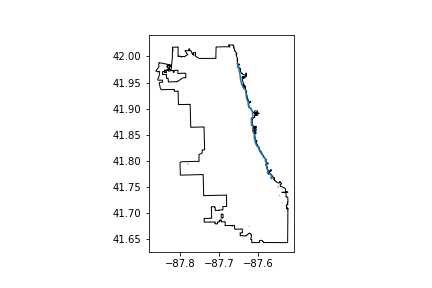

In [26]:
fig,ax = plt.subplots()

boundaries_3857.to_crs(street_df.crs).plot(ax=ax, color=[0, 0, 0, 0], edgecolor='k')
# ideal_df.to_crs(street_df.crs).plot(ax=ax)

actual_df.to_crs(street_df.crs).plot(ax=ax)


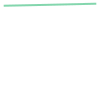

In [127]:
actual_df.iloc[11]['geometry']

In [ ]:
np.array(subset_df['cost'])

In [ ]:
dist_obj_constructor(row['geometry'], subset_df)

In [ ]:
# since this is technically integer programming, this is going to take a while unfortunately
# lp_handle = lp_maker.lp_maker(costs.tolist(), LHS.tolist(), RHS.tolist(), comp.tolist(), vlb=np.zeros(RHS.shape).tolist(), vub=np.ones(RHS.shape).tolist(), xint=np.ones(RHS.shape).tolist(), setminim=1)
lp_handle = lp_maker.lp_maker(costs.tolist(), LHS.tolist(), RHS.tolist(), comp.tolist(), setminim=1)

lpstat = lpsolve55.lpsolve('solve', lp_handle)
if lpstat == 2:
    print("Infeasible")
elif lpstat == 1:
    print("Unbounded")
elif lpstat == 0:
    connected = lpsolve55.lpsolve('get_variables', lp_handle)[0]
    actual_paths.loc[idx,'geometry'] = subset_df[connected,'geometry'].unary_union

In [ ]:
test = np.where(LHS[:,0])

In [ ]:
subset_df.iloc[test]

In [33]:
print((np.array(connected)>.5).astype(int)[14:20])
print(connected[14:20])

[1 1 1 1 1 1]
[1.0, 1.0, 0.9999999999999999, 1.0, 0.9999999999999999, 1.0]


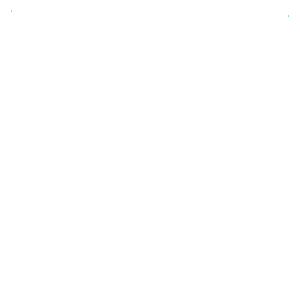

In [45]:
subset_df.iloc[np.where(np.array(connected)>.5)]['geometry'].unary_union
# subset_df[(np.array(connected)>.5).astype(int)]

# actual_paths.loc[idx,'geometry'] = subset_df.iloc[np.where(np.array(connected)>.5)[0]]['geometry'].unary_union

In [27]:
RHS

array([0., 0., 0., ..., 0., 0., 0.])

In [28]:
np.where(LHS[-1,:])
# RHS

(array([1634, 1671, 1768, 2761, 5108, 5569, 5654, 5954, 6200, 6460, 6943,
        7408, 8153, 8608, 9668, 9945], dtype=int64),)

In [29]:
np.where(LHS[-2,:])

(array([ 1247,  2619,  4133,  4269,  4312,  4526,  5158,  6017,  6717,
         6731,  7675,  7822,  7959,  8054,  8921,  8923,  9235,  9933,
        10048, 10187], dtype=int64),)

In [35]:
subset_df.iloc[np.where(connected)]

,name,length,CLASS,geometry,pre_dir,type,cost
1737,BRYN MAWR,329.658099,2,"LINESTRING (-9762625.547 5158451.375, -9762660...",W,street,133511.529897
2780,WOOD,664.023989,4,"LINESTRING (-9759312.138 5129895.812, -9759311...",S,street,268929.715500
3652,SACRAMENTO,620.439198,3,"LINESTRING (-9763022.680 5151900.698, -9763023...",N,street,251277.875307
4268,FRANCISCO,34.278295,4,"LINESTRING (-9762628.884 5148082.877, -9762628...",N,street,13882.709609


In [35]:
lpstat

2

In [75]:
np.where(np.array(connected)>.5)

(array([1163, 1839], dtype=int64),)

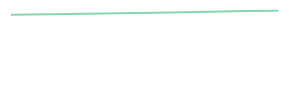

In [76]:
subset_df.iloc[np.where(np.array(connected)>.5)]['geometry'].unary_union

In [79]:
print(ideal_df.iloc[0]['geometry'].coords[2])

(-9761634.396090178, 5117090.190157592)
